# Feature Importance Analyses for Mislocalization

In [17]:
import os
import polars as pl
import seaborn as sns
# from adjustText import adjust_text
from sklearn.decomposition import PCA
# import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import glob
np.random.seed(42)
random.seed(42)

controls = {
    "TC": ["EGFP"],
    "NC": ["RHEB", "MAPK9", "PRKACB", "SLIRP"],
    "PC": ["ALK", "ALK_Arg1275Gln", "PTK2B"],
    # "cPC": ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", 
    # "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
    # "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", 
    # "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]
}

ctrl_alleles = [k_v for k_v in controls.values()]
ctrl_alleles_flat = [allele for sublist in ctrl_alleles for allele in sublist]

FEAT_SETS = ["DNA", "Mito", "GFP", "AGP", "Morph"]
PLATEMAP_DIR = "../../../1_inputs/1_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
PROF_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/batch_profiles"
CLASS_RES_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_results/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"

In [11]:
BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"

IMG_QC_DIR = f"../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/1.image_qc_outputs/{COMBINED_BIO_REP_DIR}"
CLASS_ANALYSIS_DIR = f"../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/{COMBINED_BIO_REP_DIR}"

## 1. Load feature importance and classifier info

### Feature importance from two batches

In [16]:
feat_import_df_per_feat = {}
for feat_type in FEAT_SETS:
    feat_import_df_feat = pl.DataFrame()
    for batch_id in BIO_REP_BATCHES:
        # Read the data
        feat_df = pl.read_csv(f"{CLASS_RES_DIR.format(batch_id)}/feat_importance.csv")
        meta_cols = [c for c in feat_df.columns if c.startswith("Metadata_") or c.startswith("Group") or c == "Batch"]
        feat_cols = [c for c in feat_df.columns if c not in meta_cols]
        feat_df = feat_df.with_columns([
            pl.col(c).cast(pl.Float64) for c in feat_cols
        ])
        feat_df = feat_df.with_columns(
            pl.lit(batch_id).alias("Batch")
        )
        if feat_type != "Morph":
            feat_cols = [
                i
                for i in feat_cols
                if (feat_type.lower() in i.lower())
                and ("Brightfield" not in i) ## excluding Brightfield features
            ]
        else:
            feat_cols = [
                i
                for i in feat_cols
                if ("GFP" not in i) and ("Brightfield" not in i)
            ]
        feat_df_batch = feat_df.filter(pl.col("Metadata_Feature_Type")==feat_type).select(meta_cols + feat_cols)        
        feat_import_df_feat = pl.concat([feat_import_df_feat, feat_df_batch], how="diagonal")
    feat_import_df_per_feat[feat_type] = feat_import_df_feat

In [23]:
metric_df_all_feat = pl.DataFrame()

for idx, metric_file in enumerate(glob.glob(f"{CLASS_ANALYSIS_DIR}/*.csv")):
    print(idx, metric_file)
    if idx == 0:
        feat_type_1st = metric_file.split("/")[-1].split("_")[1]
        r
    # metric_df = pl.read_csv(metric_file)
    # metric_df_all_feat = metric_df_all_feat.join(
    #     metric_df,
    #     # on="allele_0"
    # )

0 ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_DNA_summary_auroc.csv
1 ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_Morph_summary_auroc.csv
2 ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_Mito_summary_auroc.csv
3 ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_GFP_summary_auroc.csv
4 ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_AGP_summary_auroc.csv


### Filter the GFP cols

Filter the cols with all nulls and get the mean feature importance per column

In [ ]:
# Filter out columns where all values are null
non_null_cols = [col for col in feat_dfs.columns if not feat_dfs[col].is_null().all()]
feat_df_clean = feat_dfs.select(non_null_cols)

# Group by "Group1" and "Group2" and compute the mean for all columns except "batch"
feat_df_mean = feat_df_clean.group_by(["Group1", "Group2"]).agg( ## , "batch"
    pl.col("*").exclude(["Group1", "Group2", "batch"]).mean()
)

# Filter out columns where any values are null
meta_cols = [col for col in feat_df_mean.columns if "GFP" not in col]
morph_cols = [col for col in feat_df_mean.columns if "DNA" in col or "AGP" in col or "Mito" in col]
# no_null_morph_cols = [col for col in morph_cols if not feat_df_mean[col].is_null().any()] ## not feat_df_mean[col].is_nan().any() and 

feat_df_mean = feat_df_mean.select(meta_cols+no_null_morph_cols).with_columns(
    pl.when(pl.col("Group1").is_in(ctrl_alleles_flat))
    .then(pl.lit("Control"))
    .otherwise(pl.lit("Allele"))
    .alias("Variant_Type")
)

In [24]:
feat_df_clean

Group1,Group2,Cytoplasm_RadialDistribution_RadialCV_GFP_4of10,Cells_Intensity_MassDisplacement_GFP,Cytoplasm_RadialDistribution_FracAtD_GFP_7of10,Cells_Texture_Correlation_GFP_20_03_256,Cytoplasm_Granularity_1_GFP,Cytoplasm_Texture_Correlation_GFP_10_02_256,Nuclei_Granularity_3_GFP,Cytoplasm_RadialDistribution_MeanFrac_GFP_9of10,Cytoplasm_RadialDistribution_MeanFrac_GFP_10of10,Nuclei_RadialDistribution_RadialCV_GFP_5of10,Cytoplasm_RadialDistribution_FracAtD_GFP_10of10,Cells_RadialDistribution_RadialCV_GFP_7of10,Cells_Texture_InfoMeas1_GFP_5_01_256,Cells_RadialDistribution_FracAtD_GFP_5of10,Nuclei_RadialDistribution_RadialCV_GFP_4of10,Cytoplasm_Texture_InfoMeas1_GFP_5_01_256,Nuclei_Texture_Correlation_GFP_10_00_256,Cells_RadialDistribution_FracAtD_GFP_8of10,Cytoplasm_RadialDistribution_RadialCV_GFP_1of10,Cytoplasm_Texture_InfoMeas1_GFP_5_03_256,Nuclei_RadialDistribution_FracAtD_GFP_5of10,Nuclei_RadialDistribution_MeanFrac_GFP_1of10,Cells_RadialDistribution_RadialCV_GFP_9of10,Nuclei_RadialDistribution_RadialCV_GFP_1of10,Cells_Texture_InfoMeas1_GFP_5_02_256,Cytoplasm_Granularity_2_GFP,Nuclei_Texture_Correlation_GFP_10_02_256,Nuclei_Texture_Correlation_GFP_5_02_256,Cells_RadialDistribution_MeanFrac_GFP_4of10,Cells_Texture_Correlation_GFP_10_03_256,Cytoplasm_RadialDistribution_RadialCV_GFP_3of10,Cytoplasm_RadialDistribution_MeanFrac_GFP_6of10,Cells_Texture_Correlation_GFP_10_00_256,Cells_RadialDistribution_RadialCV_GFP_5of10,Nuclei_RadialDistribution_MeanFrac_GFP_7of10,…,Cytoplasm_Intensity_LowerQuartileIntensity_DNA,Cells_Texture_AngularSecondMoment_Mito_20_00_256,Cytoplasm_AreaShape_MinFeretDiameter,Nuclei_Texture_Contrast_AGP_10_02_256,Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_16of16,Nuclei_Texture_InfoMeas1_Mito_20_01_256,Cells_Texture_InfoMeas2_AGP_5_01_256,Cells_Texture_SumAverage_DNA_5_02_256,Cytoplasm_Texture_DifferenceEntropy_AGP_10_03_256,Cytoplasm_Intensity_MADIntensity_Mito,Nuclei_Neighbors_FirstClosestDistance_10,Cytoplasm_Intensity_MaxIntensity_Mito,Cytoplasm_Location_CenterMassIntensity_X_AGP,Cells_Texture_AngularSecondMoment_Mito_20_02_256,Cells_RadialDistribution_FracAtD_mito_tubeness_3of20,Cells_RadialDistribution_FracAtD_mito_tubeness_10of20,Cytoplasm_Texture_DifferenceVariance_Mito_10_03_256,Cytoplasm_Texture_AngularSecondMoment_AGP_10_03_256,Nuclei_Texture_InfoMeas1_Mito_20_03_256,Cytoplasm_Intensity_StdIntensity_Mito,Nuclei_Texture_Contrast_AGP_10_00_256,Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_13of16,Cytoplasm_Texture_DifferenceVariance_Mito_20_02_256,Cells_Correlation_K_DNA_Mito,Nuclei_Intensity_IntegratedIntensityEdge_Mito,Cells_Texture_SumAverage_DNA_20_01_256,Cytoplasm_Texture_AngularSecondMoment_Mito_10_03_256,Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_17of20,Nuclei_Correlation_K_DNA_Mito,Nuclei_Texture_SumEntropy_DNA_10_02_256,Nuclei_Texture_SumAverage_DNA_10_03_256,Nuclei_Texture_DifferenceEntropy_AGP_20_02_256,Cytoplasm_RadialDistribution_RadialCV_Mito_4of10,Cells_Correlation_Costes_AGP_DNA,Cytoplasm_Texture_DifferenceVariance_Mito_20_00_256,Cytoplasm_Texture_Entropy_Mito_10_01_256,Cells_RadialDistribution_FracAtD_mito_tubeness_18of20
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""ALK""","""G07_H07""",0.007895,0.019487,0.007647,0.007756,0.005442,0.006627,0.009828,0.008473,0.006874,0.008827,0.006974,0.007181,0.005795,0.009943,0.009086,0.007519,0.007718,0.008567,0.008128,0.010401,0.008217,0.009999,0.006581,0.006857,0.009243,0.008557,0.0061,0.008652,0.008835,0.005648,0.009254,0.008618,0.007175,0.007393,0.008351,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""ALK""","""G07_H07""",0.006056,

In [23]:
feat_df_mean[morph_cols[0]]

Cells_Texture_Correlation_AGP_5_01_256
str
null
null
null
null
null
…
null
null
null


### Mislocalization results

In [4]:
metrics_dir = "../1_snakemake_pipeline/2025_varchamp_snakemake/snakemake_pipeline/outputs/analyses/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect"
batches = ["2024_01_23_Batch_7", "2024_02_06_Batch_8"]

metrics_df, metrics_wtvar = pl.DataFrame(), pl.DataFrame()
for batch in batches:
    met_dir = metrics_dir.format(batch)
    metrics_df_batch = pl.read_csv(f"{met_dir}/metrics.csv")
    metrics_wtvar_batch = pl.read_csv(f"{met_dir}/metrics_summary.csv")

    metrics_df = pl.concat([metrics_df, metrics_df_batch])
    metrics_wtvar = pl.concat([metrics_wtvar, metrics_wtvar_batch])

## get the localization metrics
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")
## get the alleles and their reference genes
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("mislocalized")
).unique()
misloc_alleles = (
    local_wtvar
    .select("allele_0")
    .to_series()
    .to_list()
)

misloc_binary = (
    local_wtvar.pivot(
        index=["allele_0", "Allele_set"], ## , "AUROC_mean"
        columns="Batch",
        values="mislocalized",
    )
    .with_columns(
        ((pl.col("B7") == 1) & (pl.col("B8") == 1)).alias(
            "mislocalized_both_batches"
        ),
        (((pl.col("B7") == 1) & (pl.col("B8") != 1)) | ((pl.col("B7") != 1) & (pl.col("B8") == 1))).alias(
            "mislocalized_in_one_batch_only"
        ),
    )
    .rename({"B7": "mislocalized_batch7", "B8": "mislocalized_batch8"})
)

sig_misloc_alleles = misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]

In [5]:
misloc_binary

allele_0,Allele_set,mislocalized_batch7,mislocalized_batch8,mislocalized_both_batches,mislocalized_in_one_batch_only
str,str,i32,i32,bool,bool
"""SIX1_Val106Gly…","""A1P4""",0,0,false,false
"""DES_Pro433Thr""","""A1P1""",1,0,false,true
"""PMP22_His51Arg…","""A1P3""",0,0,false,false
"""KLHL3_Met78Val…","""A1P2""",0,0,false,false
"""PKP2_Asp26Asn""","""A1P3""",0,0,false,false
"""TUFM_Gly149Ser…","""A1P4""",0,0,false,false
"""CRADD_Gly128Ar…","""A1P1""",1,0,false,true
"""DES_Tyr331Asn""","""A1P1""",1,0,false,true
"""KRT86_Asn114As…","""A1P2""",1,0,false,true


In [6]:
feat_df_mean_pd = feat_df_mean.to_pandas()
feat_df_mean_pd["Allele"] = feat_df_mean_pd["Group2"].apply(lambda x: '_'.join(x.split("_")[1:]) if "_" in x else x)

## get the three classes of variants/alleles
feat_df_mean_pd_misloc_var = feat_df_mean_pd[feat_df_mean_pd["Allele"].isin(sig_misloc_alleles)]
feat_df_mean_pd_no_misloc_var = feat_df_mean_pd[~feat_df_mean_pd["Allele"].isin(sig_misloc_alleles)]
feat_df_mean_pd_ctrl_alleles = feat_df_mean_pd[feat_df_mean_pd["Variant_Type"]=="Control"][feat_df_mean_pd_misloc_var.columns]

## Important Features

### Visualize the top N (default n=10) most important features

In [17]:
def plot_top_n_important_feat(df, n=10, ax=None, title=""):
    # Calculate mean and standard deviation for each column
    column_stats = df[[col for col in df.columns if "GFP" in col]].agg(['mean', 'std']).T

    # Sort columns by the sum of mean and std in descending order
    sorted_columns = column_stats.sort_values(by=["mean"], ascending=False)
    sorted_columns = sorted_columns.head(n)
    # display(sorted_columns)

    # Plot mean and std for each column
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(y=sorted_columns.index, width=sorted_columns["mean"], color='skyblue') ## yerr=sorted_columns["std"], capsize=5, edgecolor='black'
    ax.set_yticks(range(len(sorted_columns.index)))
    ax.set_yticklabels(sorted_columns.index, rotation=0, fontsize=10)
    # ax.set_xlabel("Mean")
    ax.set_title(f"Features Importance Mean {title}")
    ax.axvline(x=0.01, color='r', linestyle='--')
    # plt.tight_layout()
    # plt.show()
    return sorted_columns

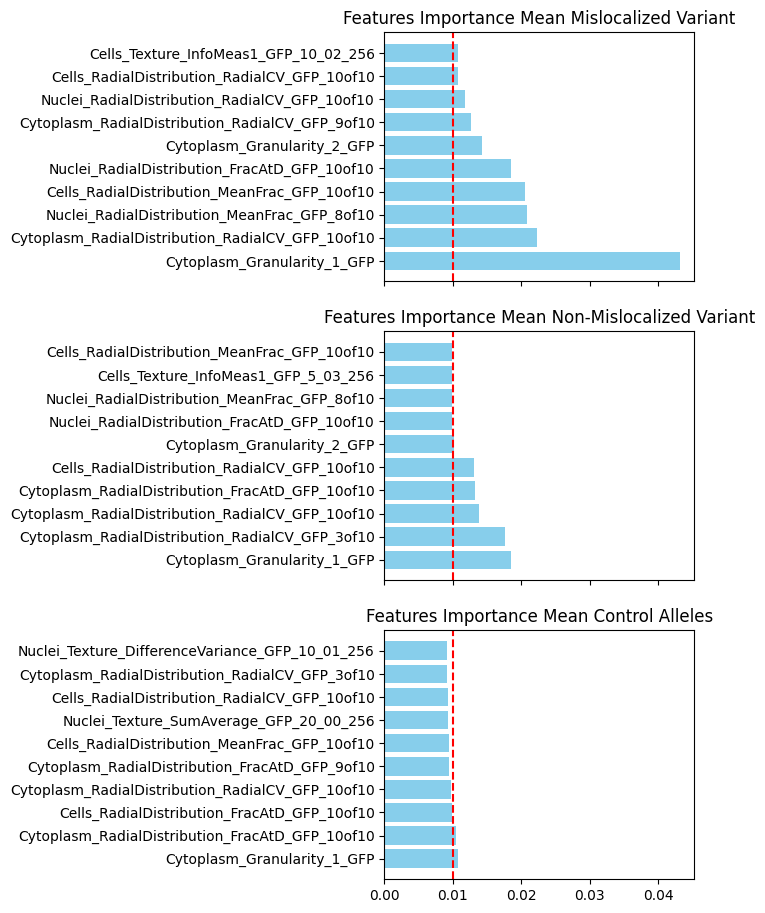

In [28]:
fig, axes = plt.subplots(3,1, figsize=(4, 11), sharex=True)
feat_import_misloc_var = plot_top_n_important_feat(feat_df_mean_pd_misloc_var, ax=axes[0], title="Mislocalized Variant")
feat_import_no_misloc_var = plot_top_n_important_feat(feat_df_mean_pd_no_misloc_var, ax=axes[1], title="Non-Mislocalized Variant")
feat_import_ctrl = plot_top_n_important_feat(feat_df_mean_pd_ctrl_alleles, ax=axes[2], title="Control Alleles")

In [30]:
feat_import_misloc_var.index #.sort_values()

Index(['Cytoplasm_Granularity_1_GFP',
       'Cytoplasm_RadialDistribution_RadialCV_GFP_10of10',
       'Nuclei_RadialDistribution_MeanFrac_GFP_8of10',
       'Cells_RadialDistribution_MeanFrac_GFP_10of10',
       'Nuclei_RadialDistribution_FracAtD_GFP_10of10',
       'Cytoplasm_Granularity_2_GFP',
       'Cytoplasm_RadialDistribution_RadialCV_GFP_9of10',
       'Nuclei_RadialDistribution_RadialCV_GFP_10of10',
       'Cells_RadialDistribution_RadialCV_GFP_10of10',
       'Cells_Texture_InfoMeas1_GFP_10_02_256'],
      dtype='object')

In [23]:
print("\n".join(sorted(set(feat_import_misloc_var.index.sort_values()).intersection(set(feat_import_no_misloc_var.index.sort_values())))))

Cells_RadialDistribution_MeanFrac_GFP_10of10
Cells_RadialDistribution_RadialCV_GFP_10of10
Cytoplasm_Granularity_1_GFP
Cytoplasm_Granularity_2_GFP
Cytoplasm_RadialDistribution_RadialCV_GFP_10of10
Nuclei_RadialDistribution_FracAtD_GFP_10of10
Nuclei_RadialDistribution_MeanFrac_GFP_8of10


In Cell Painting assays analyzed with CellProfiler, the feature called Cytoplasm_Granularity refers to the texture of the staining pattern within the cytoplasm, specifically measuring how “grainy” or “speckled” the signal is at different spatial scales.

Here’s a breakdown:

__What it Measures:__

* Granularity is a texture feature that captures the size and frequency of bright spots (or granules) in the image at multiple spatial scales.

* It’s based on morphological operations (often using granulometry) to assess how much image content (signal) is removed by a series of opening operations with structuring elements of increasing sizes.

* High granularity indicates numerous small, bright objects in the cytoplasm (e.g., vesicles, organelles).

* Low granularity implies a more uniform or diffuse staining pattern.

__How It Works in CellProfiler:__

* For each cytoplasm region, CellProfiler computes how much of the signal is lost when applying filters that remove structures below certain sizes.

* The result is a series of granularity features, each corresponding to a different scale (e.g., Cytoplasm_Granularity_1, Cytoplasm_Granularity_2, …).

* These scales correspond to different object sizes: smaller numbers = finer textures; larger numbers = coarser granules.

__In Cell Painting:__

* Different dyes highlight organelles like mitochondria, endoplasmic reticulum, Golgi, etc.

* Cytoplasm_Granularity can reflect changes in organelle morphology or distribution due to chemical or genetic perturbations.

* It’s used as a phenotypic descriptor in high-content screening and profiling.

## DR based on feature importance

### All variants and alleles

/tmp/ipykernel_183613/3239728625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_df_mean_pd_misloc_var.loc[:,"Mislocalized"] = "2_Mislocalized"
/tmp/ipykernel_183613/3239728625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_df_mean_pd_no_misloc_var.loc[:,"Mislocalized"] = "1_Non-Mislocalized"


Text(0.5, 0.97, 'PCA and UMAP of All Variants')

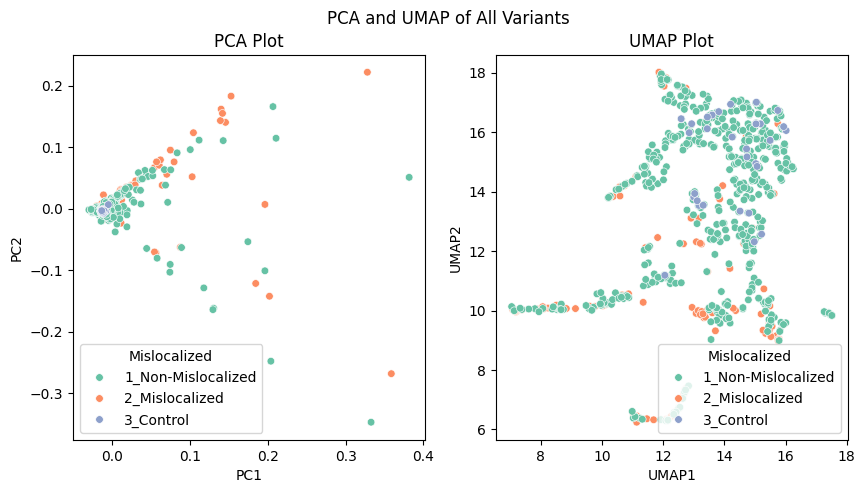

In [34]:
set2_palette = sns.color_palette("Set2", n_colors=3)

feat_df_mean_pd_misloc_var.loc[:,"Mislocalized"] = "2_Mislocalized"
feat_df_mean_pd_no_misloc_var.loc[:,"Mislocalized"] = "1_Non-Mislocalized"
feat_df_mean_pd_ctrl_alleles.loc[:,"Mislocalized"] = "3_Control"

feat_df_mean_pd_misloc_var_ctrl = pd.concat([feat_df_mean_pd_misloc_var, feat_df_mean_pd_no_misloc_var, feat_df_mean_pd_ctrl_alleles], ignore_index=True)
# display(feat_df_mean_pd_misloc_var_ctrl)

## Select the features based on the top n important features
numeric_cols = feat_df_mean_pd_misloc_var_ctrl.loc[:,feat_import_misloc_var.index]

# Standardize the features before PCA
# scaler = StandardScaler()
# numeric_cols = pd.DataFrame(scaler.fit_transform(numeric_cols), columns=numeric_cols.columns)

variant_type = feat_df_mean_pd_misloc_var_ctrl["Mislocalized"]
group2_labels = feat_df_mean_pd_misloc_var_ctrl["Allele"]

# Perform PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(numeric_cols)

# Plot PCA
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=variant_type, palette=set2_palette, s=30, ax=ax[0], hue_order=["1_Non-Mislocalized", "2_Mislocalized", "3_Control"])
# texts = []
# for i, label in enumerate(group2_labels):
#     # if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#     texts.append(ax[0].text(pca_result[i, 0], pca_result[i, 1], label, 
#                     fontsize=8, fontweight='bold', color='black'))
# # print(texts)
# adjust_text(texts, expand_points=(4, 4), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax[0]) ## 
ax[0].set_title("PCA Plot")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(numeric_cols)

sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=variant_type, palette=set2_palette, s=30, ax=ax[1], hue_order=["1_Non-Mislocalized", "2_Mislocalized", "3_Control"])
# texts = []
# for i, label in enumerate(group2_labels):
#     texts.append(ax[1].text(umap_result[i, 0], umap_result[i, 1], label, 
#                     fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax[1]) ## 
ax[1].set_title("UMAP Plot")
ax[1].set_xlabel("UMAP1")
ax[1].set_ylabel("UMAP2")
plt.suptitle("PCA and UMAP of All Variants", y=.97)

In [ ]:
# Get PCA loading scores
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=numeric_cols.columns
)
pca_loadings.sort_values(by="PC1", ascending=False, inplace=True)
pca_loadings

### Compare mislocalized variants vs control alleles

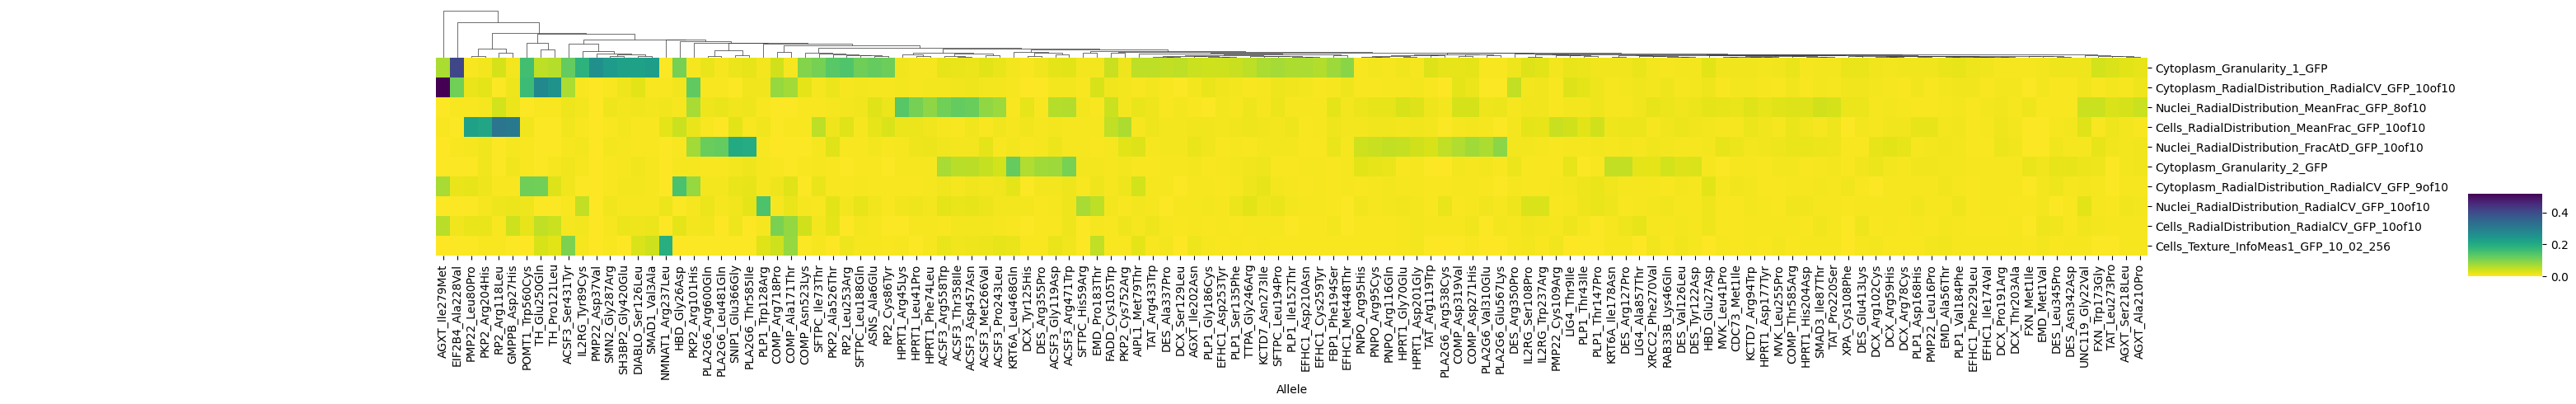

In [33]:
sns.clustermap(feat_df_mean_pd_misloc_var[["Allele"]+feat_import_misloc_var.index.to_list()].set_index("Allele").T,
xticklabels=1, cbar_pos=(1., .32, .03, .2),
figsize=(30, 5), cmap="viridis_r", row_cluster=False, col_cluster=True)

,Group1,Group2,Cytoplasm_Texture_Correlation_GFP_10_02_256,Cytoplasm_Texture_Correlation_GFP_10_03_256,Cells_RadialDistribution_MeanFrac_GFP_10of10,Cytoplasm_RadialDistribution_RadialCV_GFP_3of10,Cells_RadialDistribution_MeanFrac_GFP_6of10,Cytoplasm_Texture_Correlation_GFP_10_01_256,Cytoplasm_Texture_Correlation_GFP_20_03_256,Cells_RadialDistribution_MeanFrac_GFP_5of10,...,Nuclei_Texture_DifferenceVariance_GFP_10_01_256,Cells_RadialDistribution_MeanFrac_GFP_4of10,Nuclei_RadialDistribution_RadialCV_GFP_10of10,Nuclei_Texture_Correlation_GFP_20_03_256,Cytoplasm_Texture_InfoMeas1_GFP_10_02_256,Nuclei_RadialDistribution_FracAtD_GFP_2of10,Cells_Texture_InfoMeas1_GFP_5_01_256,Variant_Type,Allele,Mislocalized
0,EMD,EMD_EMD_Pro183Thr,0.006859,0.004087,0.007973,0.007753,0.005034,0.003104,0.007272,0.005756,...,0.010440,0.002906,0.052236,0.009291,0.025962,0.006457,0.001657,Allele,EMD_Pro183Thr,2_Mislocalized
1,DES,DES_DES_Asn342Asp,0.005487,0.006709,0.009803,0.005560,0.005161,0.005570,0.007082,0.007117,...,0.007889,0.005362,0.004734,0.003920,0.005899,0.004835,0.007237,Allele,DES_Asn342Asp,2_Mislocalized
2,DES,DES_DES_Arg355Pro,0.003320,0.003643,0.006497,0.004074,0.005004,0.003445,0.005013,0.004360,...,0.007560,0.004442,0.006028,0.004818,0.005328,0.005034,0.014418,Allele,DES_Arg355Pro,2_Mislocalized
3,COMP,COMP_COMP_Arg718Pro,0.001389,0.001449,0.002647,0.001557,0.002224,0.000660,0.003011,0.004193,...,0.001399,0.002649,0.006079,0.002232,0.010591,0.002660,0.000384,Allele,COMP_Arg718Pro,2_Mislocalized
4,TH,TH_TH_Glu250Gln,0.006133,0.001535,0.002530,0.003425,0.002642,0.002150,0.004486,0.003303,...,0.000814,0.004787,0.003464,0.000251,0.044228,0.003571,0.002010,Allele,TH_Glu250Gln,2_Mislocalized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,SLIRP,H17_H18,0.007805,0.008176,0.008424,0.007974,0.008015,0.007345,0.008492,0.008632,...,0.010735,0.007864,0.007240,0.008082,0.009076,0.008053,0.009339,Control,H18,3_Control
149,RHEB,I16_J15,0.008941,0.008731,0.010186,0.007145,0.008605,0.007804,0.008014,0.007195,...,0.009074,0.007624,0.007737,0.007523,0.008133,0.007900,0.007748,Control,J15,3_Control
150,SLIRP,G18_H18,0.008206,0.008745,0.006969,0.007454,0.007968,0.007573,0.008712,0.007812,...,0.009192,0.007286,0.008889,0.007584,0.008622,0.007738,0.009597,Control,H18,3_Control
151,SLIRP,G17_H18,0.008297,0.007452,0.008432,0.008121,0.007378,0.008754,0.008102,0.007980,...,0.008836,0.008020,0.009212,0.008499,0.008764,0.008432,0.008883,Control,H18,3_Control


Text(0.5, 0.97, 'PCA and UMAP of Mislocalzed vs Control Variants')

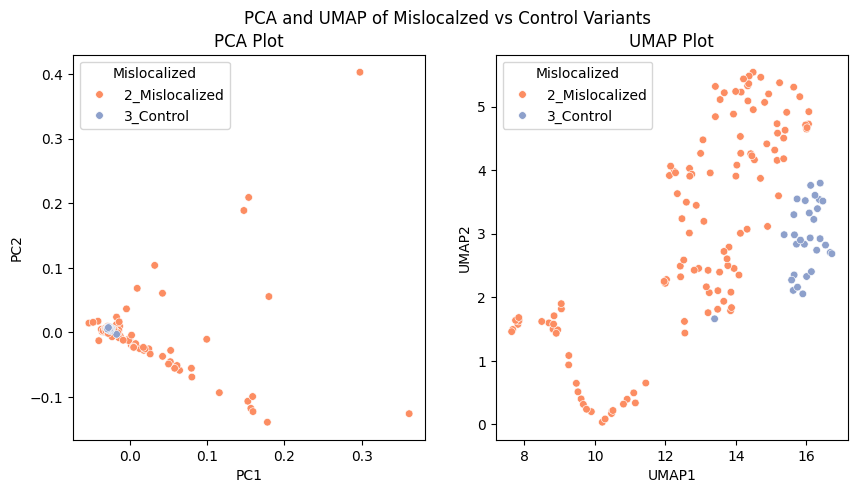

In [10]:
feat_df_mean_pd_misloc_var_ctrl = pd.concat([feat_df_mean_pd_misloc_var, feat_df_mean_pd_ctrl_alleles], ignore_index=True)
display(feat_df_mean_pd_misloc_var_ctrl)

## Select the features based on the top n important features
numeric_cols = feat_df_mean_pd_misloc_var_ctrl.loc[:,feat_import_misloc_var.index]

# Standardize the features before PCA
# scaler = StandardScaler()
# numeric_cols = pd.DataFrame(scaler.fit_transform(numeric_cols), columns=numeric_cols.columns)

variant_type = feat_df_mean_pd_misloc_var_ctrl["Mislocalized"]
group2_labels = feat_df_mean_pd_misloc_var_ctrl["Allele"]

# Perform PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(numeric_cols)

# Plot PCA
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=variant_type, palette=set2_palette[1:], s=30, ax=ax[0], hue_order=["2_Mislocalized", "3_Control"])
# texts = []
# for i, label in enumerate(group2_labels):
#     # if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#     texts.append(ax[0].text(pca_result[i, 0], pca_result[i, 1], label, 
#                     fontsize=8, fontweight='bold', color='black'))
# # print(texts)
# adjust_text(texts, expand_points=(4, 4), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax[0]) ## 
ax[0].set_title("PCA Plot")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(numeric_cols)

sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=variant_type, palette=set2_palette[1:], s=30, ax=ax[1], hue_order=["2_Mislocalized", "3_Control"])
# texts = []
# for i, label in enumerate(group2_labels):
#     texts.append(ax[1].text(umap_result[i, 0], umap_result[i, 1], label, 
#                     fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax[1]) ## 
ax[1].set_title("UMAP Plot")
ax[1].set_xlabel("UMAP1")
ax[1].set_ylabel("UMAP2")
plt.suptitle("PCA and UMAP of Mislocalzed vs Control Variants", y=.97)

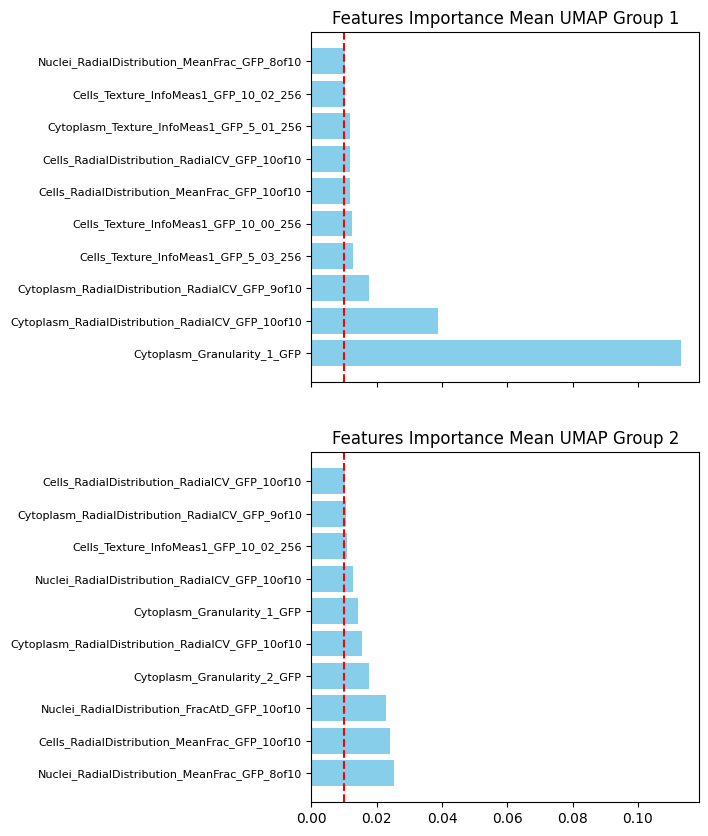

In [11]:
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df["Variant_Type"] = variant_type.to_list()
umap_df["Group2"] = group2_labels.to_list()
umap_df["Group1"] = feat_df_mean_pd_misloc_var_ctrl["Group1"].to_list()
umap_group1 = umap_df[umap_df["UMAP1"]<12]["Group2"].unique()

fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
umap_group1_fi = plot_top_n_important_feat(feat_df_mean_pd_misloc_var[feat_df_mean_pd_misloc_var["Allele"].isin(umap_group1)], 
n=10, ax=axes[0], title="UMAP Group 1")
# display(umap_group1_fi)
umap_group2_fi = plot_top_n_important_feat(feat_df_mean_pd_misloc_var[~feat_df_mean_pd_misloc_var["Allele"].isin(umap_group1)], 
n=10, ax=axes[1], title="UMAP Group 2")

In [15]:
umap_group1 #.shape

array(['IL2RG_Tyr89Cys', 'KCTD7_Asn273Ile', 'AGXT_Ile279Met',
       'ASNS_Ala6Glu', 'ACSF3_Ser431Tyr', 'HBD_Gly26Asp',
       'SFTPC_Leu188Gln', 'SH3BP2_Gly420Glu', 'DIABLO_Ser126Leu',
       'PLP1_Ser135Phe', 'DES_Ala337Pro', 'SFTPC_Leu194Pro',
       'EIF2B4_Ala228Val', 'TH_Pro121Leu', 'EFHC1_Asp253Tyr',
       'FBP1_Phe194Ser', 'POMT1_Trp560Cys', 'AIPL1_Met79Thr',
       'EFHC1_Cys259Tyr', 'AGXT_Ile202Asn', 'SMAD1_Val3Ala',
       'RP2_Cys86Tyr', 'EFHC1_Met448Thr', 'SFTPC_Ile73Thr',
       'SMN2_Gly287Arg', 'EFHC1_Asp210Asn', 'PKP2_Ala526Thr',
       'RP2_Leu253Arg', 'PLP1_Ile152Thr', 'PMP22_Asp37Val',
       'PLP1_Gly186Cys', 'TAT_Arg433Trp', 'TTPA_Gly246Arg',
       'DCX_Ser129Leu', 'COMP_Asn523Lys', 'FXN_Trp173Gly'], dtype=object)

In [13]:
umap_df["Gene"] = umap_df["Group2"].apply(lambda x: x.split("_")[0])
umap_df[umap_df["Group2"].isin(umap_group1)].groupby("Gene").count().sort_values("Group2", ascending=False)

,UMAP1,UMAP2,Variant_Type,Group2,Group1
Gene,,,,,
EFHC1,4,4,4,4,4
SFTPC,3,3,3,3,3
PLP1,3,3,3,3,3
AGXT,2,2,2,2,2
RP2,2,2,2,2,2
AIPL1,1,1,1,1,1
COMP,1,1,1,1,1
DES,1,1,1,1,1
ASNS,1,1,1,1,1


### Key features contributing to PC variantion

In [14]:
# Get PCA loading scores
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=numeric_cols.columns
)
pca_loadings.sort_values(by="PC1", ascending=False, inplace=True)
pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Cytoplasm_Granularity_1_GFP,0.833312,-0.545650,0.081416,-0.001155,0.022653,0.026489,0.001170,0.002797,0.001793,-0.001020
Cytoplasm_RadialDistribution_RadialCV_GFP_10of10,0.539058,0.830559,0.043520,-0.131805,-0.001588,0.012446,0.008246,-0.006839,0.006931,0.001015
Cells_RadialDistribution_RadialCV_GFP_10of10,0.063789,0.110814,0.040902,0.976084,0.156414,0.059746,0.019961,0.004737,-0.026841,0.007907
Cytoplasm_RadialDistribution_RadialCV_GFP_3of10,-0.009713,-0.001079,0.006670,-0.021699,-0.041001,0.414587,-0.362953,-0.646897,-0.522300,-0.053088
Cells_RadialDistribution_FracAtD_GFP_10of10,-0.011601,0.005264,-0.007788,-0.040170,-0.017044,0.463965,-0.049490,0.729123,-0.485963,-0.111266
Cytoplasm_RadialDistribution_FracAtD_GFP_9of10,-0.013295,-0.001892,-0.010641,-0.017413,-0.017469,0.438376,-0.157972,0.046617,0.318504,0.823621
Cytoplasm_RadialDistribution_FracAtD_GFP_10of10,-0.014011,0.001207,-0.009066,0.007065,-0.057277,0.490362,-0.251308,0.000841,0.623248,-0.551670
Nuclei_Texture_SumAverage_GFP_20_00_256,-0.021284,-0.010063,-0.007843,-0.048636,0.057334,0.418318,0.877222,-0.218118,-0.005468,-0.040219
Nuclei_Texture_DifferenceVariance_GFP_10_01_256,-0.028533,-0.003061,-0.012290,-0.154030,0.982934,0.027173,-0.087818,-0.001604,0.016288,-0.020550
Cells_RadialDistribution_MeanFrac_GFP_10of10,-0.095237,0.003688,0.994631,-0.036855,0.003813,0.008476,0.002620,0.008689,0.009598,0.002411


## Hierarchical Clusterings

In [27]:
feat_df_mean_pd_misloc_var 

,Group1,Group2,Cytoplasm_Texture_Correlation_GFP_10_02_256,Cytoplasm_Texture_Correlation_GFP_10_03_256,Cells_RadialDistribution_MeanFrac_GFP_10of10,Cytoplasm_RadialDistribution_RadialCV_GFP_3of10,Cells_RadialDistribution_MeanFrac_GFP_6of10,Cytoplasm_Texture_Correlation_GFP_10_01_256,Cytoplasm_Texture_Correlation_GFP_20_03_256,Cells_RadialDistribution_MeanFrac_GFP_5of10,...,Nuclei_Texture_Correlation_GFP_20_01_256,Nuclei_Texture_DifferenceVariance_GFP_10_01_256,Cells_RadialDistribution_MeanFrac_GFP_4of10,Nuclei_RadialDistribution_RadialCV_GFP_10of10,Nuclei_Texture_Correlation_GFP_20_03_256,Cytoplasm_Texture_InfoMeas1_GFP_10_02_256,Nuclei_RadialDistribution_FracAtD_GFP_2of10,Cells_Texture_InfoMeas1_GFP_5_01_256,Variant_Type,Allele
2,TAT,TAT_TAT_Arg433Trp,0.003058,0.001500,0.012786,0.003118,0.005178,0.003393,0.004884,0.003661,...,0.003021,0.003518,0.003115,0.006703,0.002661,0.003115,0.005241,0.006494,Allele,TAT_Arg433Trp
11,PKP2,PKP2_PKP2_Arg101His,0.004641,0.002277,0.016615,0.006645,0.003805,0.003119,0.003998,0.003457,...,0.000529,0.003498,0.004954,0.006461,0.000561,0.002056,0.003305,0.012839,Allele,PKP2_Arg101His
13,ACSF3,ACSF3_ACSF3_Thr358Ile,0.003593,0.003442,0.004206,0.005665,0.013756,0.003360,0.002536,0.003795,...,0.003936,0.004999,0.005975,0.016949,0.002202,0.004947,0.004751,0.010666,Allele,ACSF3_Thr358Ile
14,ACSF3,ACSF3_ACSF3_Asp457Asn,0.004439,0.004198,0.012047,0.007927,0.006609,0.007283,0.006214,0.004954,...,0.004373,0.003245,0.006442,0.020113,0.002852,0.005805,0.002999,0.002957,Allele,ACSF3_Asp457Asn
22,DES,DES_DES_Leu345Pro,0.004458,0.004585,0.007309,0.007856,0.003501,0.005725,0.008935,0.004404,...,0.003839,0.008609,0.004737,0.003856,0.003844,0.010399,0.003749,0.028110,Allele,DES_Leu345Pro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,ACSF3,ACSF3_ACSF3_Pro243Leu,0.002528,0.004011,0.011708,0.005743,0.007106,0.006757,0.004190,0.006715,...,0.002353,0.008567,0.006970,0.009627,0.001127,0.005048,0.006626,0.017887,Allele,ACSF3_Pro243Leu
643,HPRT1,HPRT1_HPRT1_Gly70Glu,0.006280,0.006666,0.008678,0.005211,0.008945,0.006422,0.005601,0.008520,...,0.009282,0.008783,0.009573,0.010289,0.006025,0.007429,0.007054,0.011114,Allele,HPRT1_Gly70Glu
654,PLA2G6,PLA2G6_PLA2G6_Val310Glu,0.002228,0.000598,0.006520,0.007346,0.004371,0.003413,0.001784,0.005958,...,0.000000,0.009410,0.005770,0.011909,0.000000,0.000158,0.003828,0.010162,Allele,PLA2G6_Val310Glu
659,PLA2G6,PLA2G6_PLA2G6_Thr585Ile,0.000000,0.000758,0.005051,0.004527,0.001770,0.000953,0.003793,0.006088,...,0.000547,0.000878,0.002076,0.020302,0.000768,0.000685,0.002178,0.000184,Allele,PLA2G6_Thr585Ile


In [40]:
feature_names = list(feat_import_misloc_var.index)
df = feat_df_mean_pd_misloc_var[["Group1", "Group2"] + feature_names].copy()

In [41]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette_scores = []
cluster_range = range(2, 10)  # Trying clusters from 2 to 9

for k in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(df[feature_names])
    score = silhouette_score(df[feature_names], labels)
    silhouette_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

# Select the number of clusters that has the highest silhouette score
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters determined: {optimal_clusters}")

Clusters: 2, Silhouette Score: 0.5992
Clusters: 3, Silhouette Score: 0.5794
Clusters: 4, Silhouette Score: 0.6153
Clusters: 5, Silhouette Score: 0.2990
Clusters: 6, Silhouette Score: 0.3305
Clusters: 7, Silhouette Score: 0.3592
Clusters: 8, Silhouette Score: 0.3446
Clusters: 9, Silhouette Score: 0.3730
Optimal number of clusters determined: 4


In [50]:
# ----------------------------
# 3. Perform Hierarchical Clustering with the Optimal Cluster Count
# ----------------------------
agg_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
df.loc[:,'cluster'] = agg_model.fit_predict(df[feature_names])

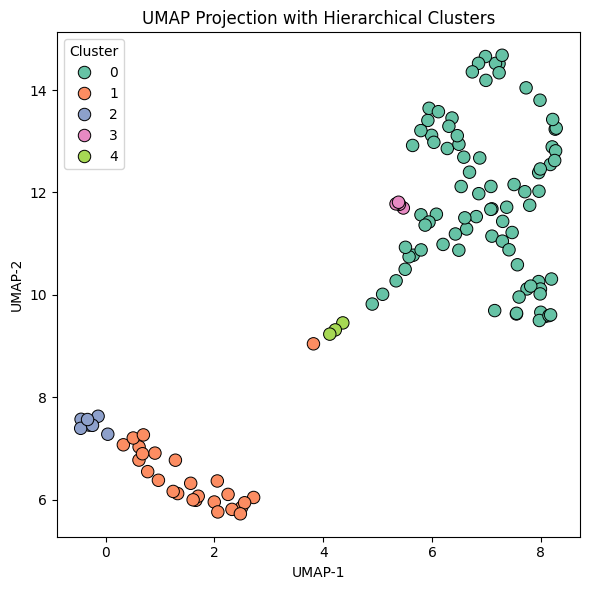

In [58]:
# ----------------------------
# 4. Compute UMAP Projection and Plot the Clusters
# ----------------------------
umap_reducer = umap.UMAP(random_state=42)
embedding = umap_reducer.fit_transform(df[feature_names])
df['UMAP-1'] = embedding[:, 0]
df['UMAP-2'] = embedding[:, 1]

plt.figure(figsize=(6, 6))
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='cluster', 
                palette='Set2', data=df, s=80, edgecolor='k')
plt.title("UMAP Projection with Hierarchical Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

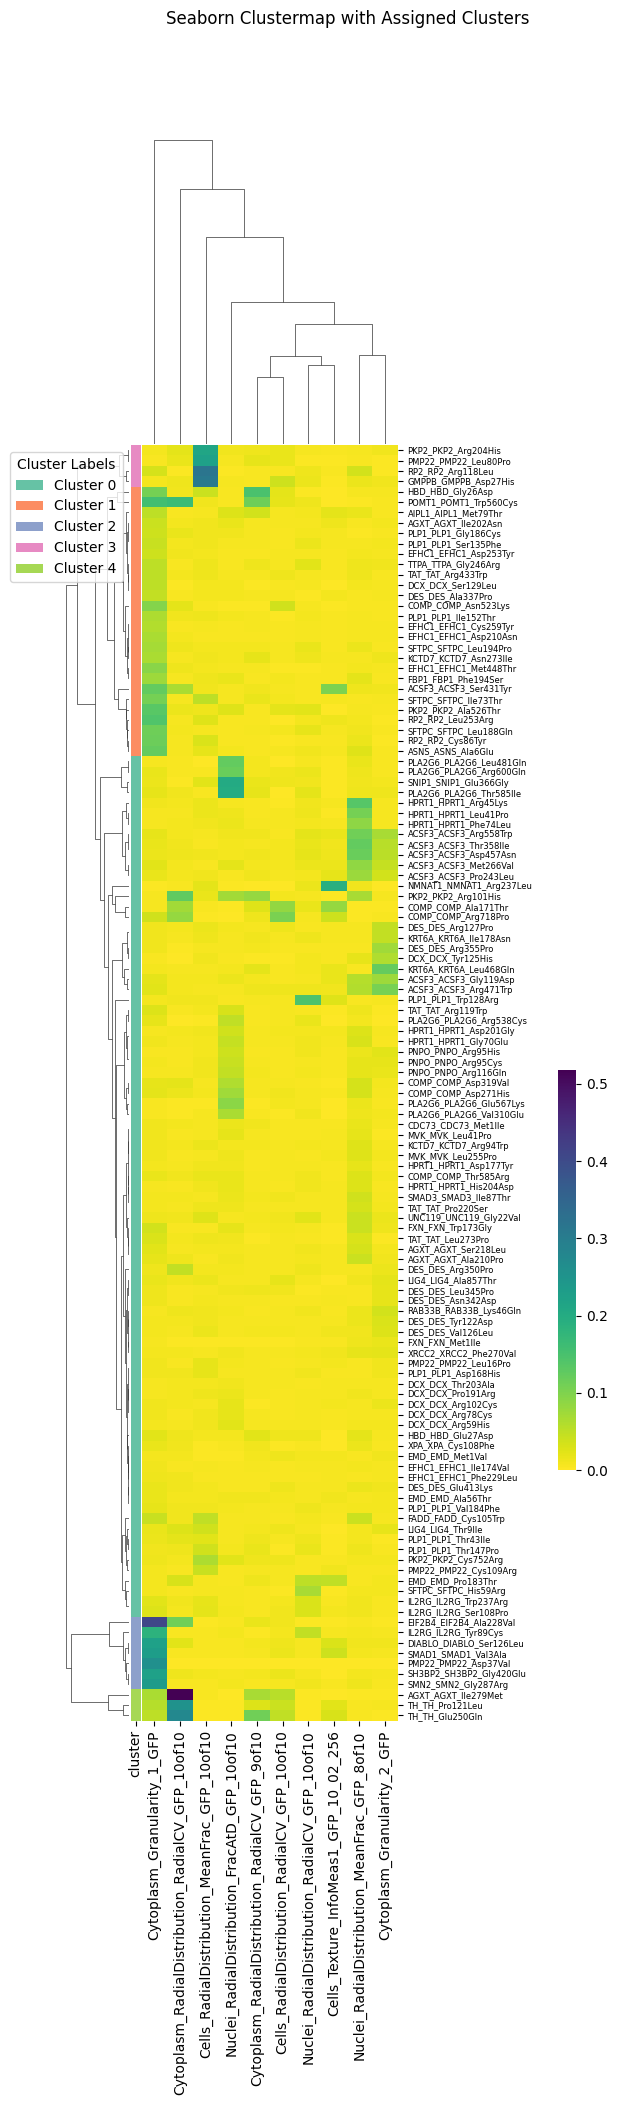

In [77]:
# df = df.set_index("Group2")
unique_clusters = np.sort(df['cluster'].unique())
palette = sns.color_palette("Set2", len(unique_clusters))
lut = dict(zip(unique_clusters, palette))
row_colors = df['cluster'].map(lut)

# Create the clustermap. We use only the original features.
# The row_colors argument is used to annotate the rows based on our clusters.
g = sns.clustermap(df[feature_names],
                   row_colors=row_colors,
                   metric="euclidean",
                   method="ward",
                   cmap="viridis_r",
                   cbar_pos=(.85, .32, .03, .2),
                   figsize=(6, 20),
                   yticklabels=df.index)

# Optionally, add a legend for the row_colors
for label in unique_clusters:
    g.ax_row_dendrogram.bar(1, 0, color=lut[label],
                            label=f'Cluster {label}', linewidth=0)
g.ax_row_dendrogram.legend(loc="upper right", ncol=1, title="Cluster Labels")
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=6)
plt.setp(g.ax_heatmap.set_ylabel(""), rotation=0, fontsize=6)
plt.suptitle("Seaborn Clustermap with Assigned Clusters", y=1.05)
plt.show()